In [1]:
#importovanje neophodnih biblioteka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#scikit learn preprocesiranje
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
#scikit learn selekcija feature-a
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
#scikit learn izbor modela
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
#sklearn metrike 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, r2_score
#sklearn modeli
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
#sklearn model selection
from sklearn.model_selection import GridSearchCV
#sklearn za crossvalidation
from sklearn.model_selection import cross_val_score, cross_validate
#auto-sklearn
#import autosklearn.classification
#import autosklearn.regression
#scikit learn neuronske mreze
from sklearn.neural_network import MLPClassifier
#sklearn genetic-opt
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic.plots import plot_fitness_evolution
from sklearn_genetic import GAFeatureSelectionCV
#feature reduction sa PCA
from sklearn.decomposition import PCA
#za handlovanje nebalansiranih datasetova
from imblearn.over_sampling import SMOTE

In [2]:
#ucitavanje podataka
file_name = "./datasets/addiction_nova.csv"
data = pd.read_csv(file_name, na_values = ' ')
data.head(10)

,ID,Pol,Godine,SkolaPoTipu,SkolaPoRegionu,Uspeh,EkonomskiPolozaj,ImaKomp,ZadovoljanPristupom,KolikoDugo,...,Internet16,Internet17,Internet18,NKP,PI,SPO,PUI,PUIcutoff,CutOff3940,CutOff4950
0,1,0.0,17.0,1,1,3.0,3.0,0.0,1.0,9.0,...,5.0,5.0,NaN,NaN,16.0,11.0,NaN,NaN,NaN,NaN
1,2,0.0,17.0,1,1,4.0,4.0,0.0,1.0,5.0,...,1.0,2.0,1.0,13.0,7.0,5.0,25.0,0.0,0.0,0.0
2,3,0.0,17.0,1,1,4.0,3.0,0.0,1.0,9.0,...,3.0,1.0,1.0,13.0,9.0,6.0,28.0,0.0,0.0,0.0
3,4,0.0,17.0,1,1,4.0,3.0,0.0,1.0,7.0,...,4.0,1.0,1.0,12.0,14.0,5.0,31.0,0.0,0.0,0.0
4,5,0.0,17.0,1,1,4.0,1.0,1.0,0.0,2.0,...,2.0,1.0,2.0,12.0,9.0,7.0,28.0,0.0,0.0,0.0
5,6,0.0,17.0,1,1,4.0,3.0,0.0,1.0,6.0,...,4.0,1.0,2.0,17.0,10.0,5.0,32.0,0.0,0.0,0.0
6,7,0.0,16.0,1,1,4.0,5.0,0.0,1.0,5.0,...,1.0,2.0,2.0,12.0,7.0,5.0,24.0,0.0,0.0,0.0
7,8,0.0,16.0,1,1,3.0,5.0,0.0,1.0,8.0,...,2.0,1.0,1.0,13.0,12.0,6.0,31.0,0.0,0.0,0.0
8,9,1.0,17.0,1,1,5.0,2.0,0.0,1.0,5.0,...,5.0,2.0,4.0,32.0,20.0,9.0,61.0,1.0,1.0,1.0
9,10,0.0,16.0,1,1,4.0,1.0,0.0,0.0,6.0,...,4.0,1.0,1.0,9.0,10.0,4.0,23.0,0.0,0.0,0.0


In [3]:
#provera da li ima duplikata
print('Broj pronadjenih duplikata: ' + str(data.duplicated().sum()))

Broj pronadjenih duplikata: 0


In [4]:
#sredjivanje kolona
#kolone ID, TEMPS1 do TEMPS36, NKP, PI, SPO, CutOff4950, EnergetskoP2 i Temper_bin ne ulaze u analizu
temp_cols=[]
for col in data.columns:
    if col.startswith('TEMPS'):
        temp_cols.append(col)
out_cols = ['ID','NKP','PI','SPO', 'CutOff4950', 'EnergetskoP2', 'Temper_bin']
for col in out_cols:
    temp_cols.append(col)
new_data = data.drop(temp_cols, axis=1)
#preimenovanje kolone
new_data.rename(columns = {'CutOff3940':'Cutoff_Class'}, inplace=True)

In [5]:
#eliminacija Internet kolona (Internet1 -> Internet18)
internet_cols=[]
for col in new_data.columns:
    if col.startswith('Internet'):
        internet_cols.append(col)
new_data = new_data.drop(internet_cols, axis=1)
print('Novi broj kolona nakon eliminacije: {}'.format(len(new_data.columns)))

Novi broj kolona nakon eliminacije: 75


In [6]:
#provera koliko ima NaN vrednosti
print(new_data.isna().sum().sort_values(ascending=False))
#za Cutoff_Class kolonu postoji 104 NaN vrednosti, to je otprilike 5% celokupnog dataset-a
#brisemo redove koji imaju NaN vrednost u Cutoff_Class koloni
new_data = new_data.dropna(subset=['Cutoff_Class', 'PUI'])

PusacKolikoGodina      208
PusacKolikoCigareta    196
Komunikacija4          145
Komunikacija2          130
Cutoff_Class           104
                      ... 
Iritabilni               0
Anksiozni                0
SkolaPoRegionu           0
SkolaPoTipu              0
FBgrupe                  0
Length: 75, dtype: int64


In [7]:
#kolone sa samo binarnim vrednostima
zero_one = ['Pol','ImaKomp','ZadovoljanPristupom','KolikoNedeljno',
                 'DaMozeDaLiBi','BrojaMailovaPosl','DaLiSvakodnevnoFb',
                 'ImaNemaFB','FBcitaPostove','FBpiseStatuse','FBdeliMuzikuFotografijeIsl', 
                 'FBigraIgrice','FBcetuje','FBgrupe','EnergetskoP1','Grickalice','Pusac',
                 'Kafa_bin','Alkohol_bin','DaLiSeDrogira','PUI']

zero_one_with_NaN = list()
for col in new_data[zero_one]:
    if(new_data[col].isna().sum()>0):
        zero_one_with_NaN.append(col)
#provera koje od ovih kolona imaju NaN vrednosti
print(new_data[zero_one].isna().sum().sort_values(ascending=False))

BrojaMailovaPosl              57
Grickalice                    39
EnergetskoP1                  33
ImaKomp                       31
KolikoNedeljno                30
DaMozeDaLiBi                  24
DaLiSvakodnevnoFb             24
Kafa_bin                      24
Alkohol_bin                   16
Pusac                         16
DaLiSeDrogira                 14
ZadovoljanPristupom           10
Pol                            1
FBdeliMuzikuFotografijeIsl     0
FBgrupe                        0
FBcetuje                       0
FBigraIgrice                   0
FBpiseStatuse                  0
FBcitaPostove                  0
ImaNemaFB                      0
PUI                            0
dtype: int64


In [8]:
#zamena vrednosti za kolone sa binarnim vrednostima koje imaju NaN vrednosti
for col in new_data[zero_one_with_NaN].columns:
    zero_row_num = new_data[col].value_counts()[0.0]
    one_row_num = new_data[col].value_counts()[1.0]
    if (zero_row_num > one_row_num):
        swap_value = 0
    else:
        swap_value = 1
    new_data[col] = new_data[col].fillna(swap_value)
print(new_data[zero_one_with_NaN].isna().sum().sort_values(ascending=False))

Pol                    0
ImaKomp                0
ZadovoljanPristupom    0
KolikoNedeljno         0
DaMozeDaLiBi           0
BrojaMailovaPosl       0
DaLiSvakodnevnoFb      0
EnergetskoP1           0
Grickalice             0
Pusac                  0
Kafa_bin               0
Alkohol_bin            0
DaLiSeDrogira          0
dtype: int64


In [9]:
#kolone gde se iste vrednosti pojavljuju cesto
repeat_value_cols = ['Godine', 'SkolaPoTipu', 'SkolaPoRegionu','Uspeh','EkonomskiPolozaj','KolikNajduze',
                     'Predhodnih6meseci','ZaStaMail','FizAkt1','FizAkt2','PusacKolikoGodina','PusacKolikoCigareta']

for col in new_data.columns:
    if (col.startswith('Sadrzaj') or col.startswith('Aktivnost') or col.startswith('Internet')):
        repeat_value_cols.append(col)
print(repeat_value_cols)

['Godine', 'SkolaPoTipu', 'SkolaPoRegionu', 'Uspeh', 'EkonomskiPolozaj', 'KolikNajduze', 'Predhodnih6meseci', 'ZaStaMail', 'FizAkt1', 'FizAkt2', 'PusacKolikoGodina', 'PusacKolikoCigareta', 'Sadrzaj1', 'Sadrzaj2', 'Sadrzaj3', 'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9', 'Sadrzaj10', 'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Aktivnost1', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4', 'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12', 'Aktivnost13', 'Aktivnost14']


In [10]:
#zamena nedostajucih vrednosti kod kolona gde se iste vrednosti pojavljuju cesto
repeat_cols_with_NaN = list()
for col in new_data[repeat_value_cols]:
    if(new_data[col].isna().sum()>0):
        repeat_cols_with_NaN.append(col)
        
for col in new_data[repeat_cols_with_NaN]:
    mode = new_data[col].mode()[0]
    new_data[col] = new_data[col].fillna(mode)
print(new_data[repeat_cols_with_NaN].isna().sum().sort_values(ascending=False))

Godine                 0
Sadrzaj10              0
Sadrzaj12              0
Sadrzaj13              0
Aktivnost1             0
Aktivnost2             0
Aktivnost3             0
Aktivnost4             0
Aktivnost5             0
Aktivnost6             0
Aktivnost7             0
Aktivnost8             0
Aktivnost9             0
Aktivnost10            0
Aktivnost11            0
Aktivnost12            0
Aktivnost13            0
Sadrzaj11              0
Sadrzaj9               0
Uspeh                  0
Sadrzaj8               0
EkonomskiPolozaj       0
KolikNajduze           0
Predhodnih6meseci      0
ZaStaMail              0
FizAkt1                0
FizAkt2                0
PusacKolikoGodina      0
PusacKolikoCigareta    0
Sadrzaj1               0
Sadrzaj2               0
Sadrzaj3               0
Sadrzaj4               0
Sadrzaj5               0
Sadrzaj6               0
Sadrzaj7               0
Aktivnost14            0
dtype: int64


In [11]:
#zamena nedostajucih vrednosti kod kolona sa nebinarnim vrednostima sa srednjom vrednoscu
filter_cols = zero_one + repeat_value_cols
non_binary_cols = new_data.columns.difference(filter_cols).values
non_binary_cols_with_NaN = list()
for col in new_data[non_binary_cols]:
    if(new_data[col].isna().sum()>0):
        non_binary_cols_with_NaN.append(col)
for col in new_data[non_binary_cols_with_NaN]:
    mean = new_data[col].mean()
    new_data[col] = new_data[col].fillna(mean)

In [12]:
#provera da li nakon preprocesiranja ima NaN vrednosti
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ): print(new_data.isna().sum().sort_values(ascending=False))

Pol                           0
FizAkt1                       0
Komunikacija3                 0
Komunikacija2                 0
Komunikacija1                 0
FBgrupe                       0
FBcetuje                      0
FBigraIgrice                  0
FBdeliMuzikuFotografijeIsl    0
FBpiseStatuse                 0
FBcitaPostove                 0
BrojaSatiFB                   0
ImaNemaFB                     0
DaLiSvakodnevnoFb             0
ZaStaMail                     0
BrojaMailovaPosl              0
BrojaMailovaPrim              0
Komunikacija4                 0
FizAkt2                       0
Aktivnost13                   0
FizAkt3                       0
PUIcutoff                     0
PUI                           0
Anksiozni                     0
Iritabilni                    0
Hipertimicni                  0
Ciklotimicni                  0
Depresivan                    0
DaLiSeDrogira                 0
Alkohol_bin                   0
Kafa_bin                      0
PusacKol

In [13]:
#provera tipova podataka
pd.set_option('display.max_rows', len(data.axes[1]))
#kolone sa float vrednostima su Depresivan, Ciklotimicni, Hipertimicni, Iritabilni, Anksiozni
int_columns = new_data.columns.difference(['Depresivan', 'Ciklotimicni', 'Hipertimicni','Iritabilni','Anksiozni', 'BrojaSatiFB']).values

In [14]:
#podesavanje input i output kolone
input_cols = new_data[new_data.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col = new_data['Cutoff_Class']

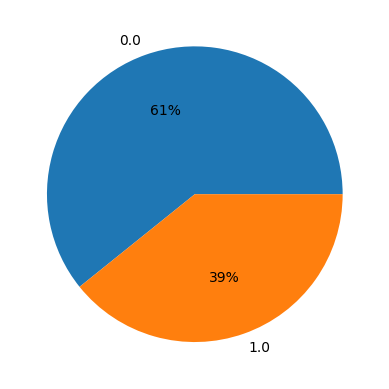

In [15]:
#pie chart za prikaz raspodele po klasama
labels = pd.unique(new_data['Cutoff_Class'])
countByClass = new_data.groupby('Cutoff_Class').size()
#colors = sns.color_palette('pastel')[0:2]
plt.pie(countByClass, labels = labels, autopct='%.0f%%')
plt.show()

Data before oversampling: (2009, 75)
Data after oversampling:  (2442, 75)


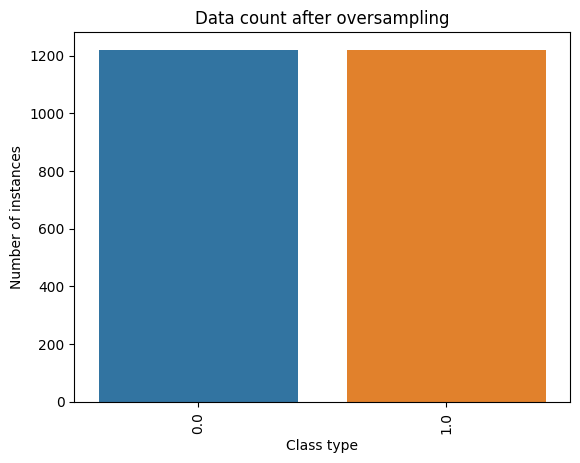

In [16]:
#oversampling sa SMOTE tehnikom
def oversampling(data):
    oversample = SMOTE()
    X_oversample, y_oversample = oversample.fit_resample(data[data.columns.difference(['Cutoff_Class'])], data['Cutoff_Class'])
    data_frame = pd.DataFrame(X_oversample)
    data_frame['Cutoff_Class'] = y_oversample
    print('Data before oversampling:', data.shape)
    print('Data after oversampling: ', X_oversample.shape)
    count_oversample = X_oversample.groupby('Cutoff_Class').size().sort_values()
    sns.barplot(x = labels, y = count_oversample, data = X_oversample)
    plt.title('Data count after oversampling')
    plt.xlabel('Class type')
    plt.xticks(rotation=90)
    plt.ylabel('Number of instances')
    plt.show()
    return data_frame
new_data_balanced = oversampling(new_data)

In [17]:
#pregled outlier vrednosti po kolonama
#detekcija outliera pomocu iqr
def find_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3=  df[col_name].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[((df[col_name]<(q1-1.5*iqr)) | (df[col_name]>(q3+1.5*iqr)))]
    return outliers
cols_to_use = new_data[new_data.columns.difference(zero_one)]
total_outlier_num=0
cols = cols_to_use.columns.values
num_cols=[]
for col in cols:
    num = find_outliers(cols_to_use, col)
    num_cols.append(len(num))
new_data_frame = pd.DataFrame()
new_data_frame['Feature']= cols
new_data_frame['Outliers']= num_cols
#print(new_data_frame.sort_values('Outliers', ascending=False))

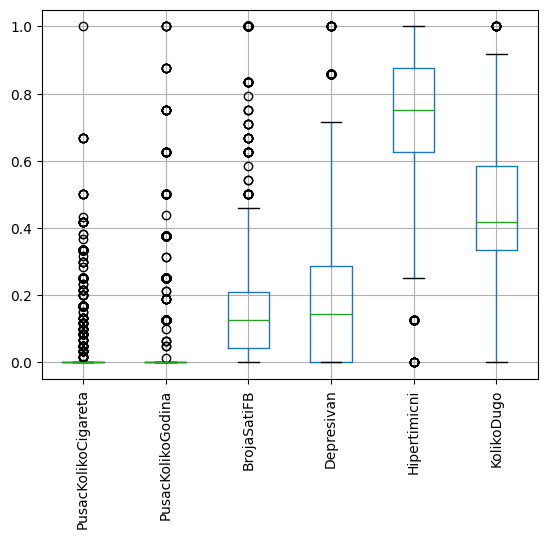

In [18]:
#ima smisla prikazivati outliere kod onih kolona gde se ne ponavljaju vrednosti iz predefinisanog skupa
outlier_cols = ['PusacKolikoCigareta','PusacKolikoGodina','BrojaSatiFB','Depresivan','Hipertimicni','KolikoDugo'] 
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
#pravimo kopiju da originalni set ne bi bio promenjen
outlier_data_norm = new_data.copy()
outlier_data_robust = new_data.copy()
outlier_data_norm[outlier_cols]= minmax_scaler.fit_transform(new_data[outlier_cols])
outlier_data_robust[outlier_cols]= robust_scaler.fit_transform(new_data[outlier_cols])
#prikaz outliera na boxplot-u
outlier_data_norm[outlier_cols].boxplot(rot=90)
#new_data[outlier_cols].boxplot(rot=90)
plt.show()
#outlier_data_robust[outlier_cols].boxplot(rot=90)

In [19]:
#detekcija i eliminacija outlier vrednosti primenom isolation forest-a
def delete_outliers(data):
    isolation_forest = IsolationForest(n_estimators = 100, contamination = 0.05, max_samples = 'auto')
    outlier_prediction = isolation_forest.fit_predict(data.values)
    print("Number of normal values detected: {}".format(outlier_prediction[outlier_prediction  == 1].sum()))
    print("Number of outliers detected: {}".format(abs(outlier_prediction[outlier_prediction == -1].sum())))
    data_no_outliers = data.copy()
    data_no_outliers['Is_Outlier'] = outlier_prediction
    data_no_outliers.drop(data_no_outliers[(data_no_outliers['Is_Outlier'] == -1)].index, axis = 0, inplace=True)
    data_no_outliers = data_no_outliers[data_no_outliers.columns.difference(['Is_Outlier'])]
    print('Number of values after eliminating outliers: ' + str(len(data_no_outliers)))
    return data_no_outliers
new_data_b_no_outliers = delete_outliers(new_data_balanced)

Number of normal values detected: 2319
Number of outliers detected: 123
Number of values after eliminating outliers: 2319


In [20]:
#normalizacija podataka -> normalizujemo sve kolone osim onih koje imaju samo binarne vrednosti 
cols_to_normalize = input_cols.columns.difference(zero_one)
min_max = MinMaxScaler()
new_data_norm = new_data_b_no_outliers.copy()
new_data_norm[cols_to_normalize] = min_max.fit_transform(new_data_norm[cols_to_normalize])

In [21]:
#standardizacija podataka
cols_to_standardize = input_cols.columns.difference(zero_one)
standard_scaler = StandardScaler()
new_data_standard = new_data_b_no_outliers.copy()
new_data_standard[cols_to_standardize] = standard_scaler.fit_transform(new_data_standard[cols_to_standardize])

In [90]:
#podela na train i test set
X_cols = new_data[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data['Cutoff_Class']

X_cols_preprocessed = new_data_norm[new_data_norm.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_preprocessed = new_data_norm['Cutoff_Class']

#treniranje sa neobradjenim i preprocesiranim skupom
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.3)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_cols_preprocessed, y_col_preprocessed, test_size=0.2)

In [ ]:
#DEO SA SELEKCIJOM FEATURE-A

In [23]:
#feture selection sa low variance metodom
def feature_selection_low_variance(treshold_val):
    variance = VarianceThreshold(threshold= treshold_val)
    variance = variance.fit(input_cols,output_col)
    good_features = variance.get_support()
    print(input_cols.columns[good_features])
print(feature_selection_low_variance(0.3))

Index(['Aktivnost1', 'Aktivnost10', 'Aktivnost11', 'Aktivnost12',
       'Aktivnost13', 'Aktivnost14', 'Aktivnost2', 'Aktivnost3', 'Aktivnost4',
       'Aktivnost5', 'Aktivnost6', 'Aktivnost7', 'Aktivnost8', 'Aktivnost9',
       'BrojaSatiFB', 'EkonomskiPolozaj', 'FizAkt1', 'FizAkt2', 'FizAkt3',
       'KolikNajduze', 'KolikoDugo', 'Komunikacija1', 'Komunikacija2',
       'Komunikacija3', 'Komunikacija4', 'Predhodnih6meseci',
       'PusacKolikoCigareta', 'PusacKolikoGodina', 'Sadrzaj1', 'Sadrzaj10',
       'Sadrzaj11', 'Sadrzaj12', 'Sadrzaj13', 'Sadrzaj2', 'Sadrzaj3',
       'Sadrzaj4', 'Sadrzaj5', 'Sadrzaj6', 'Sadrzaj7', 'Sadrzaj8', 'Sadrzaj9',
       'SkolaPoRegionu', 'SkolaPoTipu', 'Uspeh'],
      dtype='object')
None


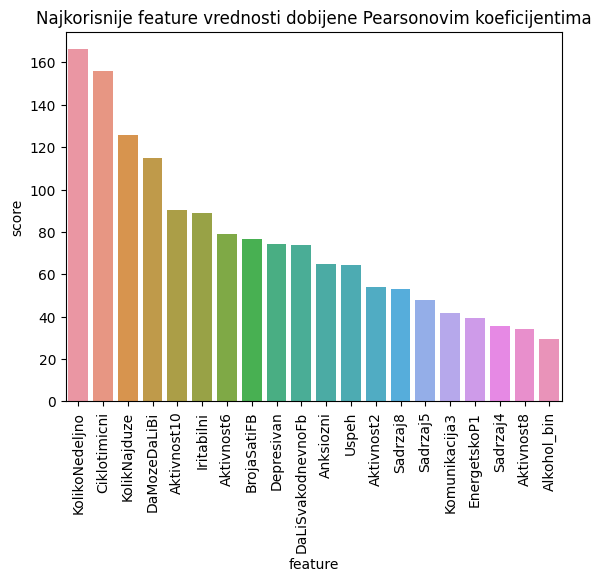

In [24]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju
def feature_selection_pearson(n_features):
    best_features = SelectKBest(score_func = f_regression, k=n_features)
    calc_features = best_features.fit(input_cols,output_col)
    #odabir najboljih feature-a
    usefull_features = pd.DataFrame({'feature' : input_cols.columns.values, 'score' : calc_features.scores_})
    most_usefull_features = usefull_features.sort_values(by=['score'],ascending=False).head(n_features)
    #vizuelizacija dobijenih rezultata
    plt.title('Najkorisnije feature vrednosti dobijene Pearsonovim koeficijentima')
    plt.xlabel('Feature score')
    plt.xticks(rotation=90)
    plt.ylabel('Naziv kolone')

    sns.barplot(x=most_usefull_features['feature'], y=most_usefull_features['score'])
    plt.show()
    feat_to_ret = most_usefull_features['feature']
    return feat_to_ret

results = feature_selection_pearson(20)

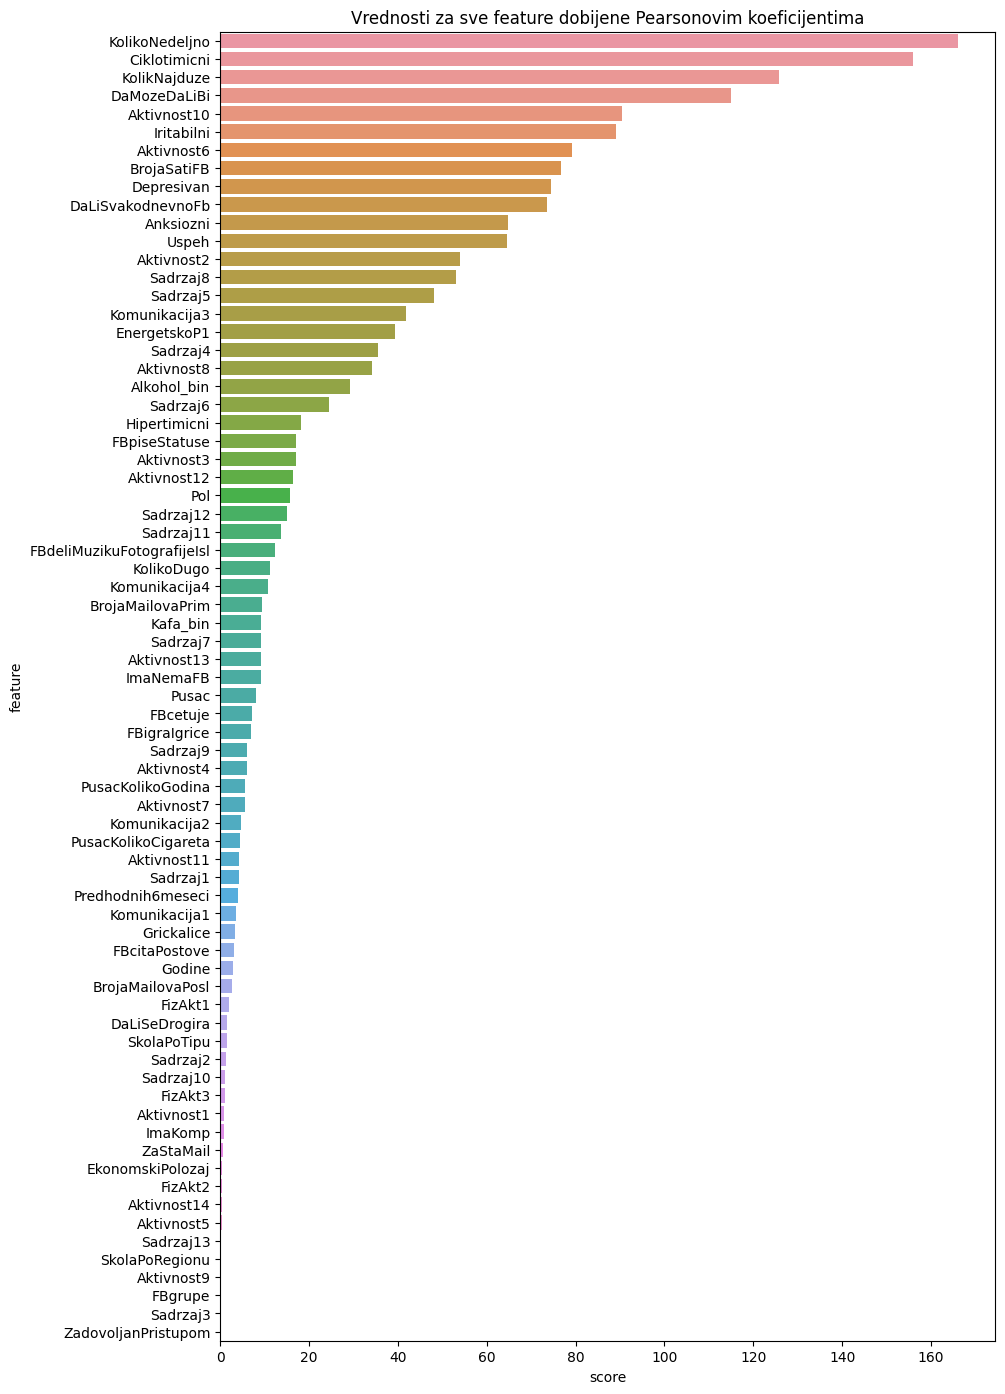

In [25]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za klasifikaciju

#varijanta sa prikazom svih atributa, nema negativnih vrednosti

def pearson_results_all():
    best_features = SelectKBest(score_func = f_regression, k=72)
    calc_features = best_features.fit(input_cols,output_col)
    #odabir najboljih feature-a
    usefull_features = pd.DataFrame({'feature' : input_cols.columns.values, 'score' : calc_features.scores_})
    usefull_features = usefull_features.sort_values(by=['score'],ascending=False)
    #vizuelizacija dobijenih rezultata
    plt.figure(figsize=(10,17))
    plt.title('Vrednosti za sve feature dobijene Pearsonovim koeficijentima')
    plt.xlabel('Feature score')
    plt.ylabel('Naziv kolone')

    sns.barplot(y=usefull_features['feature'], x=usefull_features['score'])
    plt.show()
    feat_to_ret = usefull_features['feature']

results = pearson_results_all()

Index(['KolikoNedeljno', 'KolikNajduze', 'DaMozeDaLiBi', 'Aktivnost10',
       'Ciklotimicni', 'Iritabilni', 'PUI', 'PUIcutoff', 'Cutoff_Class'],
      dtype='object')


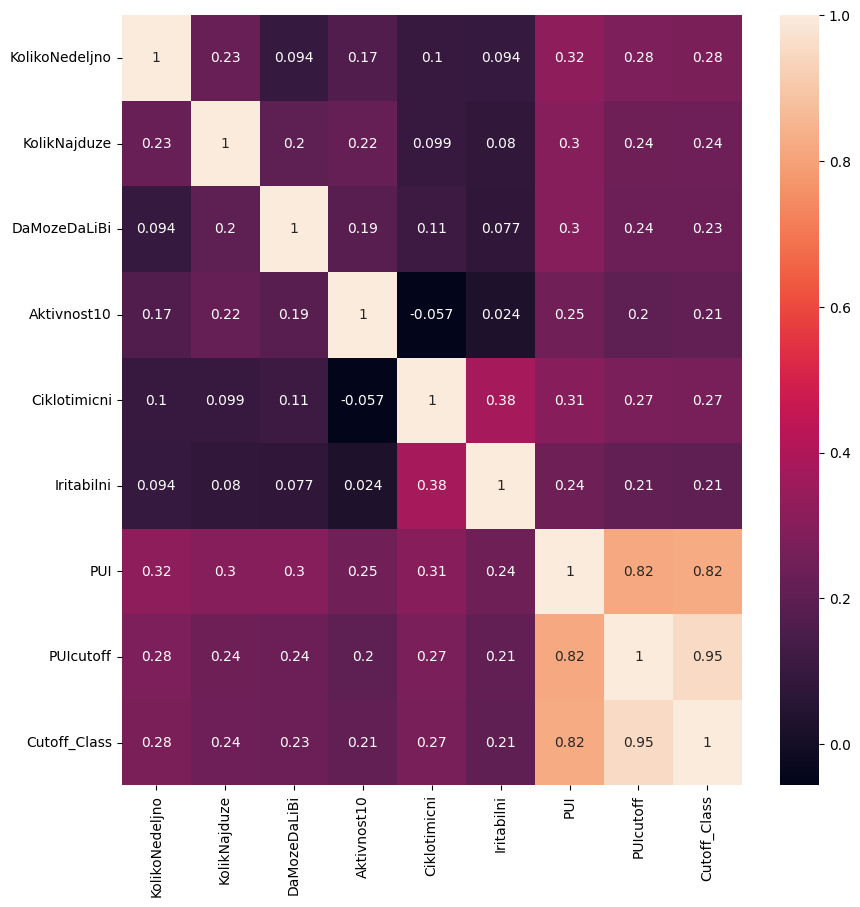

In [26]:
#prikaz heat mape gde se vide koeficijenti korelacije
def correlation_coef(corr_treshold):
    plt.figure(figsize=(10,10))
    correlation = new_data.corr()
    correlation_treshold = correlation['Cutoff_Class']
    good_features = correlation_treshold[abs(correlation_treshold > corr_treshold )]
    print(str(good_features.keys()))
    #print(good_features.sort_values(ascending=False))
    sns.heatmap(new_data[good_features.keys()].corr(), annot=True)
correlation_coef(0.2)

In [27]:
#DEO SA KLASIFIKACIJOM

#modeli bez podesavanja hiperparametara
decision_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()
random_forest = RandomForestClassifier()
grad_boost_class = GradientBoostingClassifier()

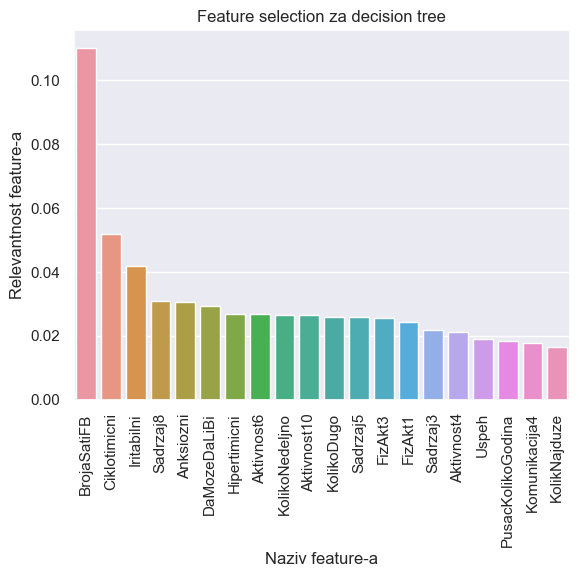

18          BrojaSatiFB
19         Ciklotimicni
40           Iritabilni
65             Sadrzaj8
15            Anksiozni
22         DaMozeDaLiBi
37         Hipertimicni
10           Aktivnost6
44       KolikoNedeljno
1           Aktivnost10
43           KolikoDugo
62             Sadrzaj5
34              FizAkt3
32              FizAkt1
60             Sadrzaj3
8            Aktivnost4
69                Uspeh
53    PusacKolikoGodina
48        Komunikacija4
42         KolikNajduze
Name: attr_names, dtype: object

In [28]:
#feature selection za decision tree
def feature_selection_decision_tree(n_features):
    sns.set()
    decision_tree.fit(X_cols, y_col)
    values = decision_tree.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.barplot(x = tree_features['attr_names'], y=tree_features['values'])
    title = 'Feature selection za decision tree'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_decision_tree_features = tree_features['attr_names']
    return best_decision_tree_features
feature_selection_decision_tree(20)

In [30]:
#prikaz rezultata za sve feature vrednosti, nema negativnih vrednosti
def feature_score_dtc():
    sns.set()
    decision_tree.fit(X_cols, y_col)
    values = decision_tree.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False)
    return tree_features
print(feature_score_dtc())

                    attr_names    values
18                 BrojaSatiFB  0.105540
19                Ciklotimicni  0.052841
40                  Iritabilni  0.042356
10                  Aktivnost6  0.031232
34                     FizAkt3  0.030380
37                Hipertimicni  0.029436
22                DaMozeDaLiBi  0.029265
65                    Sadrzaj8  0.029123
44              KolikoNedeljno  0.026688
1                  Aktivnost10  0.026592
62                    Sadrzaj5  0.024760
15                   Anksiozni  0.024647
69                       Uspeh  0.020630
13                  Aktivnost9  0.018735
32                     FizAkt1  0.018673
57                   Sadrzaj12  0.018609
42                KolikNajduze  0.018581
43                  KolikoDugo  0.018468
67              SkolaPoRegionu  0.018287
60                    Sadrzaj3  0.017333
48               Komunikacija4  0.017325
3                  Aktivnost12  0.016795
50           Predhodnih6meseci  0.015451
47              

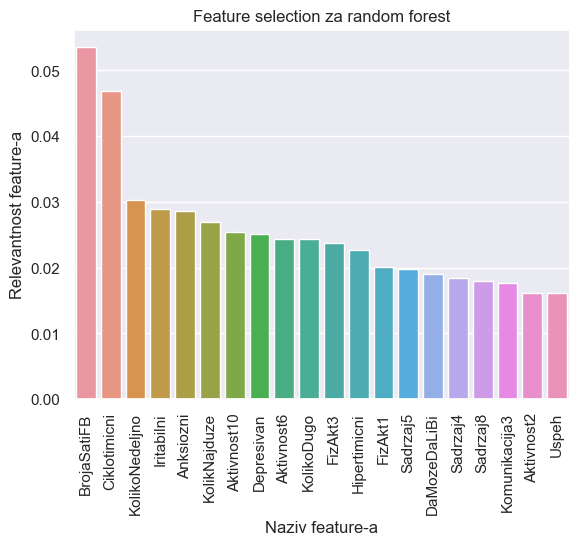

18       BrojaSatiFB
19      Ciklotimicni
44    KolikoNedeljno
40        Iritabilni
15         Anksiozni
42      KolikNajduze
1        Aktivnost10
23        Depresivan
10        Aktivnost6
43        KolikoDugo
34           FizAkt3
37      Hipertimicni
32           FizAkt1
62          Sadrzaj5
22      DaMozeDaLiBi
61          Sadrzaj4
65          Sadrzaj8
47     Komunikacija3
6         Aktivnost2
69             Uspeh
Name: attr_names, dtype: object

In [31]:
#feature selection za random forest
def feature_selection_random_forest(n_features):
    random_forest.fit(X_cols, y_col)
    values = random_forest.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False).head(n_features)
    sns.barplot(x = tree_features['attr_names'], y=tree_features['values'])
    title = 'Feature selection za random forest'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
    #cuvanje najkorisnijih feature-a
    best_random_forest_features = tree_features['attr_names']
    return best_random_forest_features
feature_selection_random_forest(20)

In [32]:
#feature score za random forest, nema negativnih vrednosti
def feature_score_rfc():
    random_forest.fit(X_cols, y_col)
    values = random_forest.feature_importances_
    attr_names = X_cols.columns.values
    tree_features = pd.DataFrame({'attr_names':attr_names, 'values':values})
    tree_features = tree_features.sort_values(by='values', ascending=False)
    return tree_features
    
print(feature_score_rfc())

                    attr_names    values
18                 BrojaSatiFB  0.061770
19                Ciklotimicni  0.042807
40                  Iritabilni  0.034830
15                   Anksiozni  0.027290
1                  Aktivnost10  0.026400
44              KolikoNedeljno  0.026001
23                  Depresivan  0.025610
10                  Aktivnost6  0.024294
42                KolikNajduze  0.023913
43                  KolikoDugo  0.023431
37                Hipertimicni  0.022568
34                     FizAkt3  0.022115
62                    Sadrzaj5  0.021548
32                     FizAkt1  0.019693
65                    Sadrzaj8  0.017937
61                    Sadrzaj4  0.017886
22                DaMozeDaLiBi  0.017565
47               Komunikacija3  0.017505
69                       Uspeh  0.016293
64                    Sadrzaj7  0.016015
57                   Sadrzaj12  0.015423
2                  Aktivnost11  0.015291
0                   Aktivnost1  0.015251
56              

In [51]:
#feature selection sa LassoCV modelom 
def feature_selection_lasso_cv(n_features):
    lasso = LassoCV(cv=3)                                                   
    lasso.fit(X_cols, y_col)      
    lasso_values = lasso.coef_
    attr_names = X_cols.columns.values
    #lasso_features = pd.DataFrame({'attr_names':attr_names, 'values': lasso_values})
    lasso_features_abs = pd.DataFrame({'attr_names':attr_names, 'values': abs(lasso_values)})
    lasso_features_abs = lasso_features_abs.sort_values(by='values', ascending=False).head(n_features)       
    #cuvanje najkorisnijih feature-a
    best_lasso_features_abs = lasso_features_abs['attr_names']
    return best_lasso_features_abs
feature_selection_lasso_cv(20)

19         Ciklotimicni
44       KolikoNedeljno
22         DaMozeDaLiBi
15            Anksiozni
21    DaLiSvakodnevnoFb
37         Hipertimicni
42         KolikNajduze
69                Uspeh
40           Iritabilni
62             Sadrzaj5
23           Depresivan
61             Sadrzaj4
65             Sadrzaj8
10           Aktivnost6
70            ZaStaMail
47        Komunikacija3
1           Aktivnost10
48        Komunikacija4
54             Sadrzaj1
32              FizAkt1
Name: attr_names, dtype: object

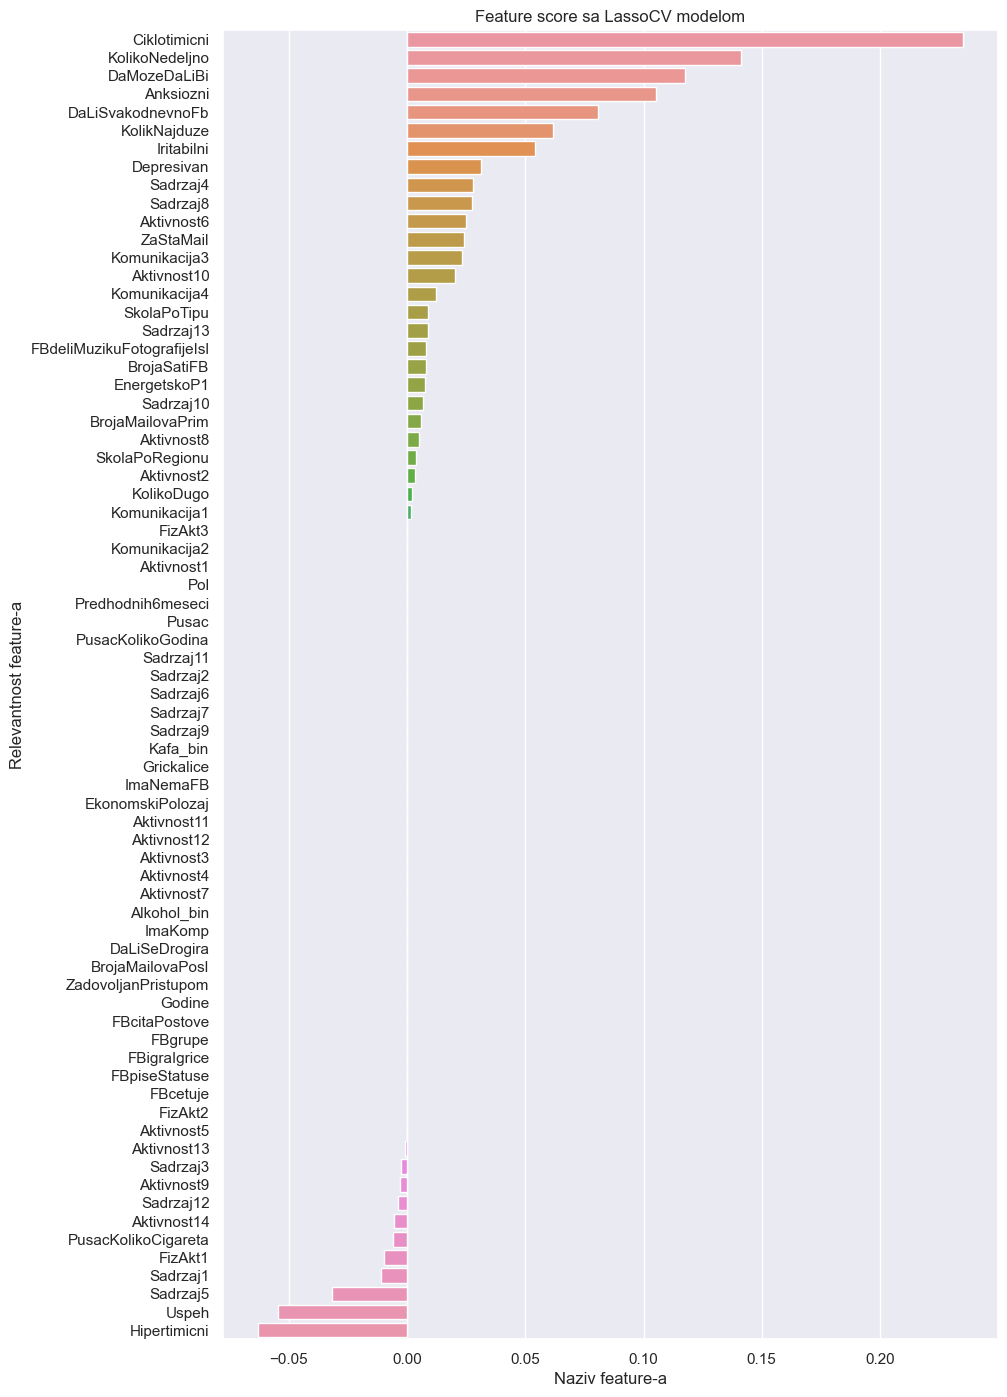

In [36]:
#feature score sa LassoCV modelom 
def feature_score_lasso_cv():
    lasso = LassoCV(cv=3)                                                   
    lasso.fit(X_cols, y_col)      
    lasso_values = lasso.coef_
    attr_names = X_cols.columns.values
    lasso_features = pd.DataFrame({'attr_names':attr_names, 'values':lasso_values})
    lasso_features = lasso_features.sort_values(by='values', ascending=False)  
    plt.figure(figsize=(10,17))
    sns.barplot(y = lasso_features['attr_names'], x=lasso_features['values'])
    title = 'Feature score sa LassoCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.ylabel('Relevantnost feature-a')
    plt.show()
feature_score_lasso_cv()

In [53]:
#feature selection koriscenjem ElasticNetCV modela
def feature_selection_elasticnet_cv(n_features):
    el_net = ElasticNetCV(cv=3)
    el_net.fit(X_cols, y_col)
    el_net_values = el_net.coef_
    attr_names = X_cols.columns.values
    el_net_features = pd.DataFrame({'attr_names':attr_names, 'values': abs(el_net_values)})
    el_net_features = el_net_features.sort_values(by='values', ascending=False).head(n_features)       
    #cuvanje najkorisnijih feature-a
    best_el_net_features = el_net_features['attr_names']
    return best_el_net_features
print(feature_selection_elasticnet_cv(20))

19         Ciklotimicni
44       KolikoNedeljno
22         DaMozeDaLiBi
15            Anksiozni
21    DaLiSvakodnevnoFb
37         Hipertimicni
42         KolikNajduze
40           Iritabilni
69                Uspeh
23           Depresivan
62             Sadrzaj5
61             Sadrzaj4
65             Sadrzaj8
70            ZaStaMail
10           Aktivnost6
47        Komunikacija3
1           Aktivnost10
48        Komunikacija4
54             Sadrzaj1
32              FizAkt1
Name: attr_names, dtype: object


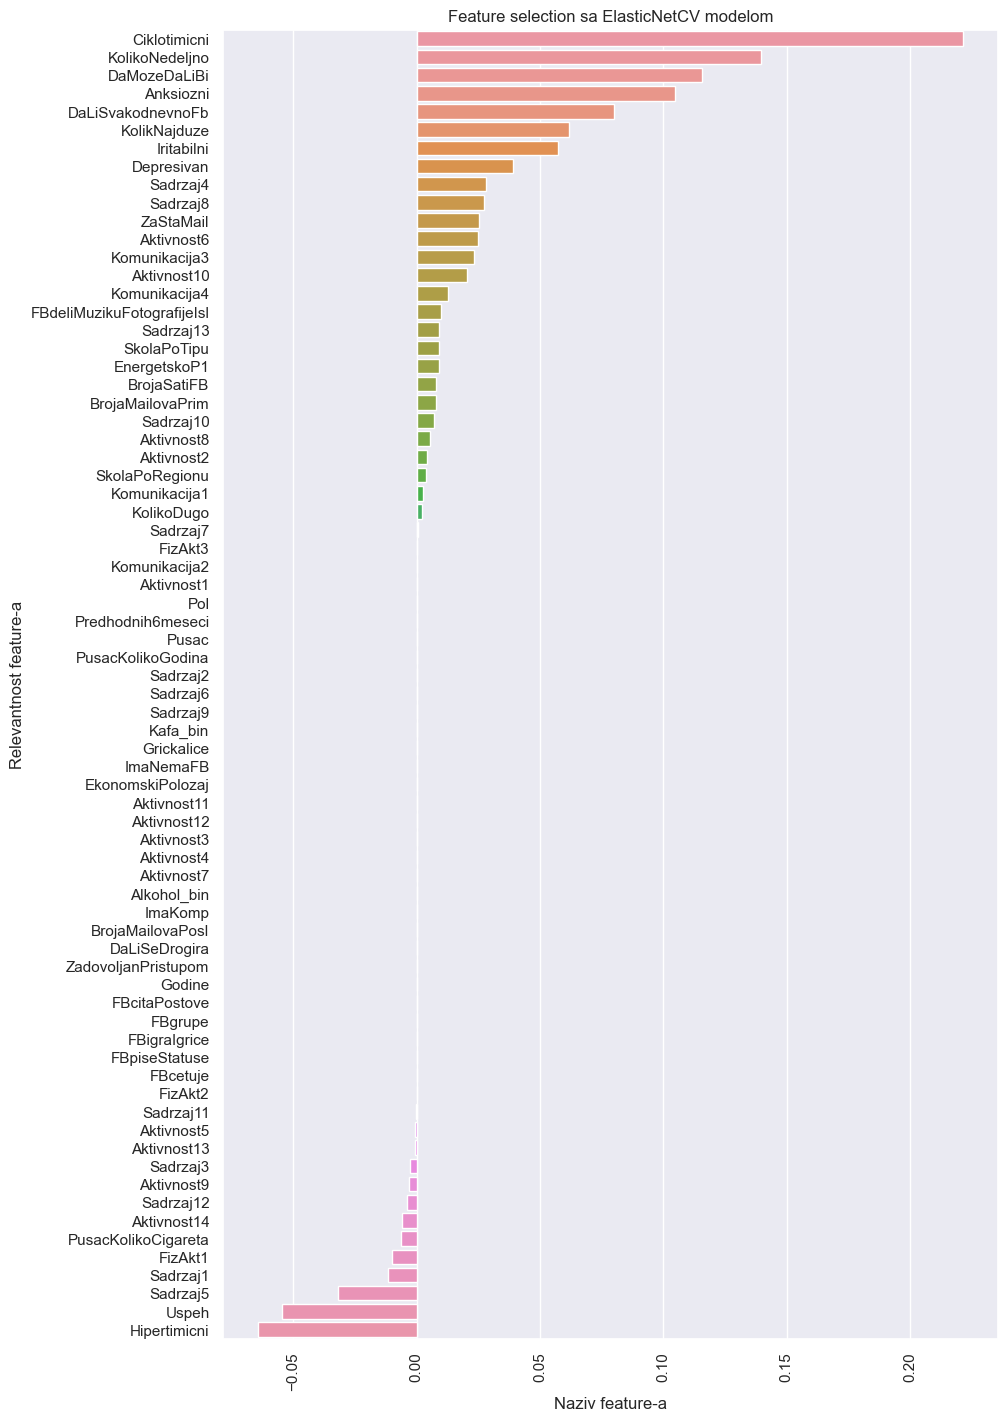

In [40]:
#feature selection koriscenjem ElasticNetCV modela
def feature_score_elasticnet_cv():
    el_net = ElasticNetCV(cv=3)
    el_net.fit(X_cols, y_col)
    el_net_values = el_net.coef_
    attr_names = X_cols.columns.values
    el_net_features = pd.DataFrame({'attr_names':attr_names, 'values':el_net_values})
    el_net_features = el_net_features.sort_values(by='values', ascending=False)  
    plt.figure(figsize=(10,17))
    sns.barplot(y = el_net_features['attr_names'], x =el_net_features['values'])
    title = 'Feature selection sa ElasticNetCV modelom'
    plt.title(title)
    plt.xlabel('Naziv feature-a')
    plt.xticks(rotation=90)
    plt.ylabel('Relevantnost feature-a')
    plt.show()
feature_score_elasticnet_cv()

Classification report sa svim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72       355
         1.0       0.54      0.20      0.29       248

    accuracy                           0.60       603
   macro avg       0.58      0.54      0.51       603
weighted avg       0.58      0.60      0.55       603

Classification report sa redukovanim feature-ima za PCA: 
              precision    recall  f1-score   support

         0.0       0.65      0.84      0.73       355
         1.0       0.61      0.35      0.45       248

    accuracy                           0.64       603
   macro avg       0.63      0.60      0.59       603
weighted avg       0.63      0.64      0.61       603



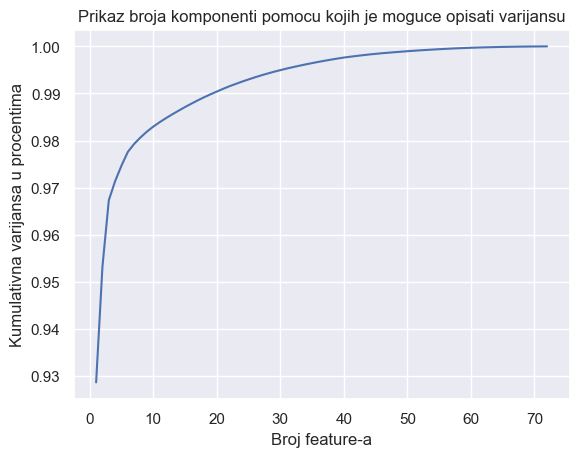

In [42]:
#primena principal component analysis na problem redukcije feature-a
pca = PCA(n_components = None)
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.fit_transform(X_test)

fig, ax = plt.subplots()
x = np.arange(1,73, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.xlabel('Broj feature-a')
plt.ylabel('Kumulativna varijansa u procentima')
plt.title('Prikaz broja komponenti pomocu kojih je moguce opisati varijansu')
plt.plot(x,y)
clr = RandomForestClassifier()
clr.fit(X_train_new, y_train)

y_pred_pca = clr.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred_pca)
print('Classification report sa svim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))

#broj komponenti predstavljen vrednoscu nakon koje se uocava zaravnjenje krive
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
clr = RandomForestClassifier()
clr.fit(X_train_pca, y_train)

y_pred_pca = clr.predict(X_test_pca)
print('Classification report sa redukovanim feature-ima za PCA: \n' + (classification_report(y_test, y_pred_pca)))


In [55]:
# k-fold cross-validation za razne modele ML-a
models = [
            ('Decision Tree', decision_tree), 
            ('Gaussian Naive Bayes', naive_bayes), 
            ('K-Nearest Neighbors', knn), 
            ('Random Forest', random_forest),
            ('Gradient Boosting Classifier', grad_boost_class)]
results = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
names = []
k_fold = StratifiedKFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['accuracy', 'precision','recall','f1'])
    results.append(cv_res)
    results_accuracy.append(cv_res['test_accuracy'].mean())
    results_precision.append(cv_res['test_precision'].mean())
    results_recall.append(cv_res['test_recall'].mean())
    results_f1.append(cv_res['test_f1'].mean())
    names.append(name)

In [56]:
#tabelarni prikaz rezultata za razlicite modele bez preprocesiranja
diff_models_res = pd.DataFrame({'Model name': names,
                                'Accuracy': results_accuracy,
                                'Precision': results_precision, 
                                'Recall': results_recall,
                                'F1': results_f1})
print(diff_models_res)

                     Model name  Accuracy  Precision    Recall        F1
0                 Decision Tree  0.638749   0.529283  0.538889  0.532489
1          Gaussian Naive Bayes  0.684235   0.579189  0.651852  0.612019
2           K-Nearest Neighbors  0.620947   0.509774  0.364815  0.423814
3                 Random Forest  0.731150   0.716225  0.496296  0.583707
4  Gradient Boosting Classifier  0.725471   0.662111  0.581481  0.618071


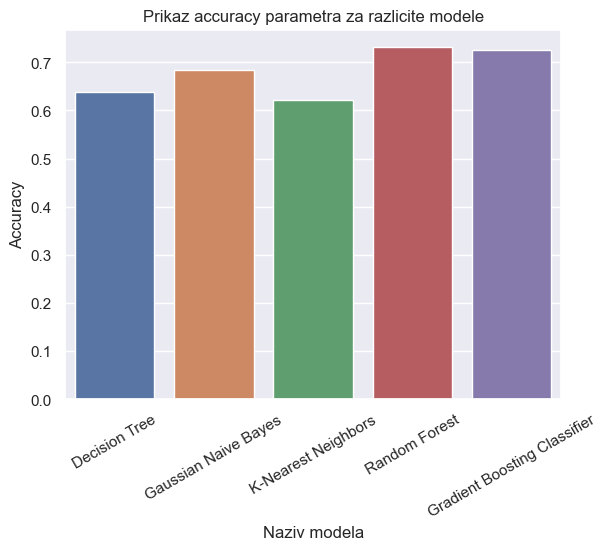

In [57]:
#vizuelizacija dobijenih rezultata za accuracy
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'accuracy':results_accuracy})
sns.barplot(x = frame['model_name'], y=frame['accuracy'])
title = 'Prikaz accuracy parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Accuracy')
plt.show()

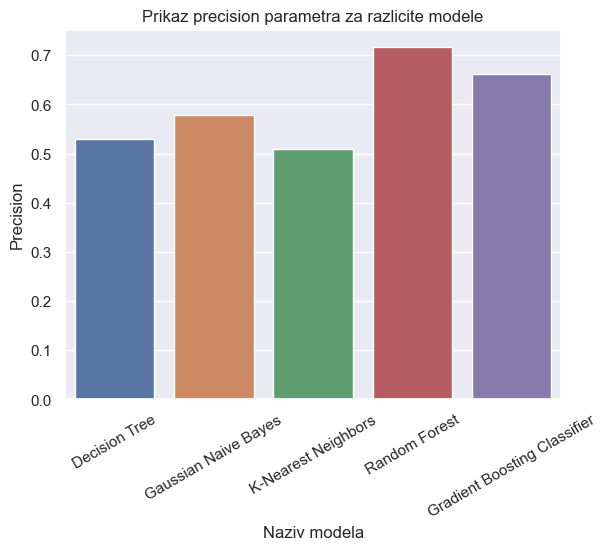

In [58]:
#vizuelizacija dobijenih rezultata za precision
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'precision':results_precision})
sns.barplot(x = frame['model_name'], y=frame['precision'])
title = 'Prikaz precision parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Precision')
plt.show()

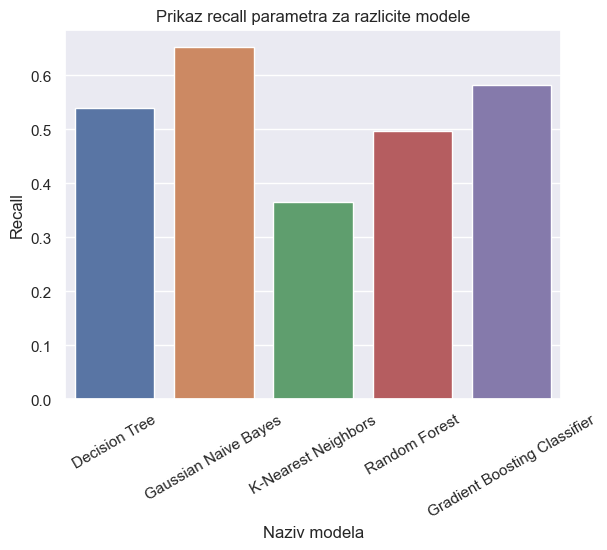

In [59]:
#vizuelizacija dobijenih rezultata za recall
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'recall':results_recall})
sns.barplot(x = frame['model_name'], y=frame['recall'])
title = 'Prikaz recall parametra za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Recall')
plt.show()

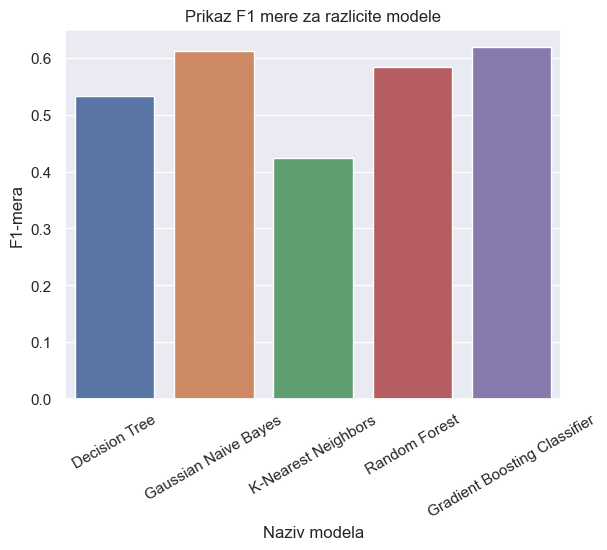

In [60]:
#vizuelizacija dobijenih rezultata za f1
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'f1':results_f1})
sns.barplot(x = frame['model_name'], y=frame['f1'])
title = 'Prikaz F1 mere za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('F1-mera')
plt.show()

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(max_depth=5, max_leaf_nodes=7)
Accuracy za dataset sa svim feature-ima: 0.70
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.71      0.84      0.77       355
         1.0       0.68      0.50      0.58       248

    accuracy                           0.70       603
   macro avg       0.69      0.67      0.67       603
weighted avg       0.70      0.70      0.69       603



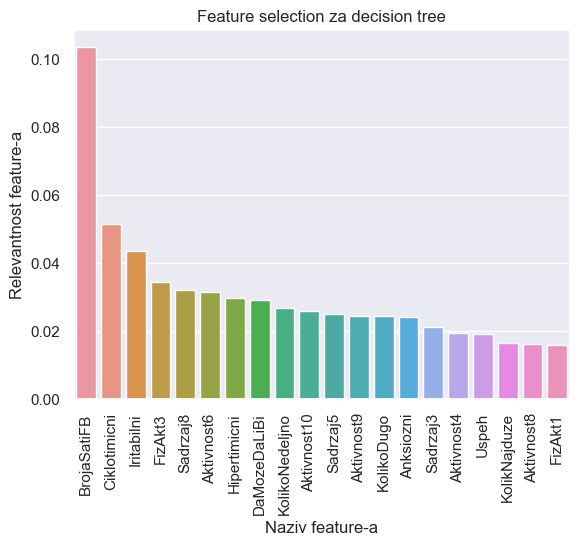

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=8)
Accuracy za preprocesiran dataset: 0.69
Classification report za preprocesiran dataset: 
              precision    recall  f1-score   support

         0.0       0.63      0.89      0.74       229
         1.0       0.82      0.49      0.62       235

    accuracy                           0.69       464
   macro avg       0.72      0.69      0.68       464
weighted avg       0.72      0.69      0.68       464



In [61]:
#podesavanje hiperparametara za decision tree
parameters = {'max_leaf_nodes': list(range(2,10)), 
              'min_samples_split':[2,3,4],
              'max_depth': [2,3,5,10],
              'criterion': ['gini', 'entropy']}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela bez preprocesiranja i sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa preprocesiranjem i selekcijom najboljih feature-a
features_dtc = feature_selection_decision_tree(20)
best_model = grid_search_cv.fit(X_train_p[features_dtc], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_dtc])
print('Accuracy za preprocesiran dataset: {:.2f}'.format(best_model.score(X_test_p[features_dtc], y_test_p)))
print('Classification report za preprocesiran dataset: ')
print(classification_report(y_test_p, y_preds))

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(criterion='entropy', max_depth=9, max_features=6,
                       n_estimators=40)
Accuracy za dataset sa svim feature-ima: 0.71
Classification report za dataset sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78       355
         1.0       0.71      0.49      0.58       248

    accuracy                           0.71       603
   macro avg       0.71      0.67      0.68       603
weighted avg       0.71      0.71      0.70       603



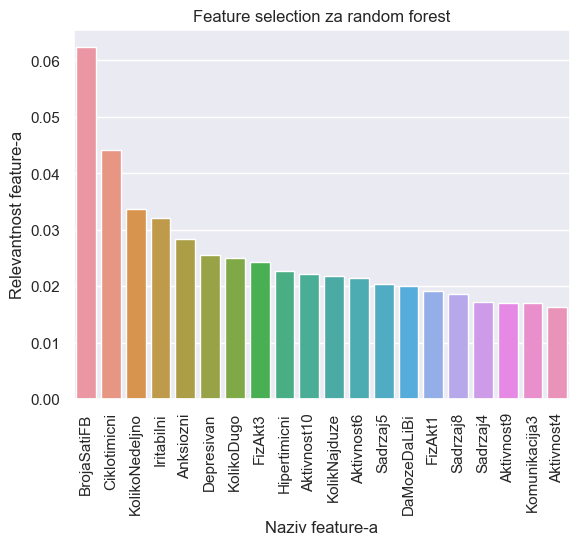

Fitting 10 folds for each of 90 candidates, totalling 900 fits
RandomForestClassifier(criterion='entropy', max_depth=9, max_features=7,
                       n_estimators=40)
Accuracy za dataset sa preprocesiranim podacima: 0.79
Classification report za dataset sa preprocesiranim podacima: 
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       229
         1.0       0.80      0.77      0.78       235

    accuracy                           0.79       464
   macro avg       0.79      0.79      0.79       464
weighted avg       0.79      0.79      0.79       464



In [62]:
#podesavanje hiperparametara za random forest
parameters = {'n_estimators':[10,20,40], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela bez preprocesiranja i sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za dataset sa svim feature-ima: {:.2f}'.format(best_model.score(X_test, y_test)))
print('Classification report za dataset sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa selekcijom feature-a i preprocesiranim podacima
features_rf = feature_selection_random_forest(20)
best_model = grid_search_cv.fit(X_train_p[features_rf], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_rf])
print('Accuracy za dataset sa preprocesiranim podacima: {:.2f}'.format(best_model.score(X_test_p[features_rf], y_test_p)))
print('Classification report za dataset sa preprocesiranim podacima: ')
print(classification_report(y_test_p, y_preds))

In [63]:
#podesavanje hiperparametara za K-Nearest-Neighbors
parameters = {'n_neighbors': list(range (1,21)), 
              'metric': ['euclidean', 'manhattan', 'minkowski'], 
              'weights': ['uniform', 'distance']}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima bez preprocesiranja: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima bez preprocesiranja: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa preprocesiranim podacima i selekcijom feature-a

#treniranje modela sa Elastic-Net feature-ima

features_elastic = feature_selection_elasticnet_cv(20)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy za model sa Elastic-Netom i preprocesiranim podacima: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report sa Elastic-Netom i sa preprocesiranim podacima: ')
print(classification_report(y_test_p, y_preds))


Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=17)
Accuracy za model sa svim feature-ima bez preprocesiranja: 0.6268656716417911
Classification report za model sa svim feature-ima bez preprocesiranja: 
              precision    recall  f1-score   support

         0.0       0.63      0.89      0.74       355
         1.0       0.62      0.25      0.35       248

    accuracy                           0.63       603
   macro avg       0.62      0.57      0.54       603
weighted avg       0.62      0.63      0.58       603

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')
Accuracy za model sa Elastic-Netom i preprocesiranim podacima: 0.771551724137931
Classification report sa Elastic-Netom i sa preprocesiranim podacima: 
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       2

In [64]:
#podesavanje hiperparametara za gradient boosting
parameters = {"n_estimators":[5,50,70],
              "max_depth":[1,3,5,7,9,11],
              "learning_rate":[0.01,0.1,1,10,100]}
grid_search_cv = GridSearchCV(GradientBoostingClassifier(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima i bez preprocesiranja podataka
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy: {}'.format(best_model.score(X_test, y_test)))
print('Classification report: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa ElasticNet feature-ima i preprocesiranim podacima
features_elastic = feature_selection_elasticnet_cv(20)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report: ')
print(classification_report(y_test_p, y_preds))

Fitting 10 folds for each of 90 candidates, totalling 900 fits
GradientBoostingClassifier(n_estimators=50)
Accuracy: 0.7164179104477612
Classification report: 
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.77       355
         1.0       0.69      0.56      0.62       248

    accuracy                           0.72       603
   macro avg       0.71      0.69      0.70       603
weighted avg       0.71      0.72      0.71       603

Fitting 10 folds for each of 90 candidates, totalling 900 fits
GradientBoostingClassifier(learning_rate=1, max_depth=1, n_estimators=50)
Accuracy: 0.7693965517241379
Classification report: 
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       229
         1.0       0.78      0.76      0.77       235

    accuracy                           0.77       464
   macro avg       0.77      0.77      0.77       464
weighted avg       0.77      0.77      0.77       4

In [67]:
#podesavanje hiperparametara za Naive Bayes
parameters = {'var_smoothing': np.logspace(0,-9,num=100)}
grid_search_cv = GridSearchCV(GaussianNB(), parameters,verbose=1,cv=10, n_jobs = -1)

#treniranje modela sa svim feature-ima i bez preprocesiranja podataka
best_model = grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test)
print('Accuracy za model sa svim feature-ima: {}'.format(best_model.score(X_test, y_test)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test, y_preds))

#treniranje modela sa Elastic-Net feature-ima i preprocesiranim podacima 
features_elastic = feature_selection_lasso_cv(10)
best_model = grid_search_cv.fit(X_train_p[features_elastic], y_train_p)
print(grid_search_cv.best_estimator_)
y_preds = best_model.predict(X_test_p[features_elastic])
print('Accuracy za model sa Lasso feature-ima: {}'.format(best_model.score(X_test_p[features_elastic], y_test_p)))
print('Classification report za model sa svim feature-ima: ')
print(classification_report(y_test_p, y_preds))


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=1.2328467394420658e-05)
Accuracy za model sa svim feature-ima: 0.6981757877280266
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       355
         1.0       0.63      0.65      0.64       248

    accuracy                           0.70       603
   macro avg       0.69      0.69      0.69       603
weighted avg       0.70      0.70      0.70       603

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.23101297000831597)
Accuracy za model sa Lasso feature-ima: 0.7025862068965517
Classification report za model sa svim feature-ima: 
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71       229
         1.0       0.72      0.69      0.70       235

    accuracy                           0.70       464
   macr

In [68]:
#genetski algoritmi
parameters = {'n_estimators':[10,50,100], 
              'criterion': ['gini', 'entropy'],
              'max_features': list(range(3,8)),
              'max_depth': [2,4,9]
               }
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 11),
              'max_leaf_nodes': Integer(2, 15),
              'n_estimators': Integer(100,300)}

clf = RandomForestClassifier()

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                              cv=cv,
                              scoring='accuracy',
                              n_jobs=-1,
                              param_grid = param_grid,
                              verbose=True)

evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.667083	0.0391703  	0.733999   	0.615931   
1  	100   	0.689402	0.0281797  	0.733999   	0.615931   
2  	100   	0.712245	0.0162086  	0.733999   	0.669271   
3  	100   	0.721905	0.00640688 	0.732576   	0.694173   
4  	100   	0.724038	0.00538735 	0.732576   	0.699163   
5  	100   	0.726343	0.00421197 	0.735419   	0.71693    
6  	100   	0.726984	0.00428991 	0.735419   	0.714787   
7  	100   	0.726144	0.00476502 	0.735419   	0.715508   
8  	100   	0.72667 	0.00493842 	0.735419   	0.716928   
9  	100   	0.725364	0.00611604 	0.735419   	0.710539   
10 	100   	0.726429	0.00518155 	0.735419   	0.710539   
11 	100   	0.725946	0.00662278 	0.735419   	0.711938   
12 	100   	0.726001	0.00559888 	0.735419   	0.714082   
13 	100   	0.727026	0.00484729 	0.735419   	0.714785   
14 	100   	0.727824	0.00574267 	0.740413   	0.715492   
15 	100   	0.728506	0.00505974 	0.740413   	0.717643   
16 	100   	0.727584	0.00582816 	0.740413   	0.71

GASearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(bootstrap=False, max_depth=10,
                                            max_leaf_nodes=13,
                                            min_weight_fraction_leaf=0.014676429783047663,
                                            n_estimators=182),
           n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categorical object at 0x0000016E8B294090>,
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x0000016E8B168150>,
                       'max_leaf_nodes': <sklearn_genetic.space.space.Integer object at 0x0000016EFF307290>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x0000016E8B1683D0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x0000016E8B168AD0>},
           return_train_score=True, scoring='accuracy')

In [92]:
#rezultati koriscenjem genetskih algoritama
y_predict_ga = evolved_estimator.predict(X_test)
print(accuracy_score(y_test, y_predict_ga))

0.7645107794361525


In [95]:
#feature selection koriscenjem genetskih algoritama
clf = RandomForestClassifier()
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=30,
    generations=20,
    n_jobs=-1,
    verbose=True,
    keep_top_k=2,
    elitism=True,
)
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	30    	0.69952	0.0159267  	0.717624   	0.655754   
1  	60    	0.710471	0.00692562 	0.731851   	0.696285   
2  	60    	0.717323	0.00846653 	0.729727   	0.696302   
3  	60    	0.722824	0.00647888 	0.733273   	0.711235   
4  	60    	0.723653	0.00758512 	0.733273   	0.699842   
5  	60    	0.72733 	0.00418148 	0.733277   	0.717636   
6  	60    	0.726739	0.00534944 	0.733277   	0.714784   
7  	60    	0.727141	0.00443648 	0.733277   	0.716925   
8  	60    	0.728564	0.00355436 	0.734706   	0.721896   
9  	60    	0.729012	0.00405848 	0.73541    	0.719764   
10 	60    	0.729275	0.00398701 	0.734706   	0.721188   
11 	60    	0.730532	0.00380031 	0.736838   	0.719754   
12 	60    	0.731955	0.00452722 	0.742534   	0.716217   
13 	60    	0.734088	0.0046475  	0.74395    	0.726866   
14 	60    	0.735322	0.00470145 	0.74395    	0.725452   
15 	60    	0.736722	0.00582477 	0.74395    	0.723317   
16 	60    	0.738144	0.0040476  	0.74395    	0.7311

GAFeatureSelectionCV(estimator=RandomForestClassifier(), generations=20,
                     keep_top_k=2, n_jobs=-1, population_size=30,
                     return_train_score=True, scoring='accuracy')

In [96]:
#feature selection koriscenjem genetskih alogiritama 
gen_opt_features = evolved_estimator.best_features_
gen_df = pd.DataFrame({'feature': X_train.columns, 'is_used':gen_opt_features})

def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

selected_features = gen_df[gen_df['is_used'] == True]['feature']
gen_df.style.applymap(highlight_cells)

,feature,is_used
0,Aktivnost1,False
1,Aktivnost10,True
2,Aktivnost11,True
3,Aktivnost12,False
4,Aktivnost13,False
5,Aktivnost14,False
6,Aktivnost2,False
7,Aktivnost3,False
8,Aktivnost4,True
9,Aktivnost5,False


In [97]:
#predikcija koriscenjem feature-a odabranih genetskim algoritmom
y_predict_ga = evolved_estimator.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_predict_ga)
print(accuracy)

0.7379767827529021


In [79]:
#radimo sa standardizovanim datasetom
X_cols_norm = new_data_norm[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col_norm = new_data_norm['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)

In [80]:
#neuronske mreze za klasifikaciju
X_cols = new_data_standard[new_data.columns.difference(['Cutoff_Class', 'PUIcutoff', 'PUI' ])]
y_col = new_data_standard['Cutoff_Class']
X_train, X_test, y_train, y_test = train_test_split(X_cols, y_col, test_size=0.2)
mlp = MLPClassifier(
    hidden_layer_sizes=(40,),
    max_iter= 90,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)
trained_model = mlp.fit(X_train, y_train)
y_preds = trained_model.predict(X_test)
plt.show()
print('Accuracy za dataset sa MLP-om: {:.2f}'.format(trained_model.score(X_test, y_test)))
print('Classification report za model sa MLP-om: ')
print(classification_report(y_test, y_preds))

Iteration 1, loss = 0.61838744
Iteration 2, loss = 0.51635407
Iteration 3, loss = 0.46842019
Iteration 4, loss = 0.43060505
Iteration 5, loss = 0.38699841
Iteration 6, loss = 0.35676439
Iteration 7, loss = 0.30570228
Iteration 8, loss = 0.26821529
Iteration 9, loss = 0.23506812
Iteration 10, loss = 0.20240830
Iteration 11, loss = 0.17985400
Iteration 12, loss = 0.15744844
Iteration 13, loss = 0.12951663
Iteration 14, loss = 0.10834192
Iteration 15, loss = 0.09111102
Iteration 16, loss = 0.07287004
Iteration 17, loss = 0.05464636
Iteration 18, loss = 0.04091737
Iteration 19, loss = 0.03285476
Iteration 20, loss = 0.02750584
Iteration 21, loss = 0.02338369
Iteration 22, loss = 0.01884302
Iteration 23, loss = 0.01666180
Iteration 24, loss = 0.01456784
Iteration 25, loss = 0.01274384
Iteration 26, loss = 0.01122486
Iteration 27, loss = 0.01022707
Iteration 28, loss = 0.00942013
Iteration 29, loss = 0.00883784
Iteration 30, loss = 0.00809461
Iteration 31, loss = 0.00758350
Iteration 32, los

In [39]:
#auto-sklearn za klasifikaciju
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))
print(automl.leaderboard())

Accuracy score 0.746268656716418
          rank  ensemble_weight           type      cost  duration
model_id                                                          
5            1             0.14  random_forest  0.242938  2.457265
18           2             0.04  random_forest  0.244821  2.536645
2            3             0.20  random_forest  0.246704  2.158461
6            4             0.08  random_forest  0.246704  2.341989
15           5             0.08  random_forest  0.256121  2.601341
11           6             0.16  random_forest  0.258004  3.490302
16           7             0.30    extra_trees  0.265537  6.225641


In [162]:
#DEO SA REGRESIJOM

In [40]:
linear = LinearRegression(n_jobs = -1)
logistic = LogisticRegression(max_iter=10000, solver='lbfgs')
lasso = Lasso(random_state = 42)
ridge = Ridge(random_state = 42)
kr = KernelRidge()
el_net= ElasticNet(random_state=42)
gradient_boost = GradientBoostingRegressor(random_state =42)
random_forest =  RandomForestRegressor(n_jobs = -1)

In [41]:
input_cols_reg = new_data_standard[new_data_standard.columns.difference(['Cutoff_Class','PUIcutoff','PUI'])]
output_col_reg = new_data_standard['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg, output_col_reg, test_size=0.3)

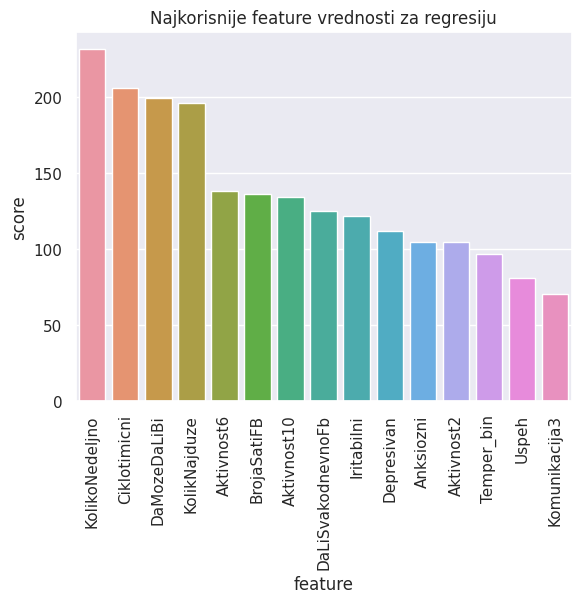

In [42]:
#feature selection sa Pearsonovim koeficijentom, input numericki, output numericki, za regresiju
best_features = SelectKBest(score_func = f_regression, k=15)
calc_features = best_features.fit(input_cols_reg,output_col_reg)
#odabir najboljih feature-a
usefull_features = pd.DataFrame({'feature' : input_cols_reg.columns.values, 'score' : calc_features.scores_})
most_usefull_features_reg = usefull_features.sort_values(by=['score'],ascending=False).head(15)
#vizuelizacija dobijenih rezultata
plt.title('Najkorisnije feature vrednosti za regresiju')
plt.xlabel('Feature score')
plt.xticks(rotation=90)
plt.ylabel('Naziv kolone')

sns.barplot(x=most_usefull_features_reg['feature'], y=most_usefull_features_reg['score'])
plt.show()

In [43]:
#pravljenje seta sa najznacajnijim feature-ima za regresiju
input_cols_reg_new = new_data[most_usefull_features_reg['feature']]
output_col_reg_new = new_data['PUI']
X_train, X_test, y_train, y_test = train_test_split(input_cols_reg_new, output_col_reg_new, test_size=0.2)

In [44]:
#odabir modela za regresiju
models = [  ('Linear Regression', linear), 
            ('Logistic Regression', logistic),
            ('Lasso', lasso), 
            ('Ridge', ridge), 
            ('Elastic Net', el_net), 
            ('Gradient Boosting', gradient_boost),
            ('Random Forest Regression', random_forest)]
results = []
results_mean_squared_error = []
results_root_mean_squared_error = []
results_r2_score = []
names = []
k_fold = KFold(n_splits=10)
for name, model in models:
    cv_res = cross_validate(model, X_train, y_train, cv=k_fold, scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error','r2'])
    results.append(cv_res)
    results_mean_squared_error.append(cv_res['test_neg_mean_squared_error'].mean())
    results_root_mean_squared_error.append(cv_res['test_neg_root_mean_squared_error'].mean())
    results_r2_score.append(cv_res['test_r2'].mean())
    names.append(name)

                 model_name  neg_mean_squared_error
0         Linear Regression             -125.371367
1       Logistic Regression             -194.605509
2                     Lasso             -149.103258
3                     Ridge             -125.358402
4               Elastic Net             -148.196487
5         Gradient Boosting             -126.684727
6  Random Forest Regression             -130.002434


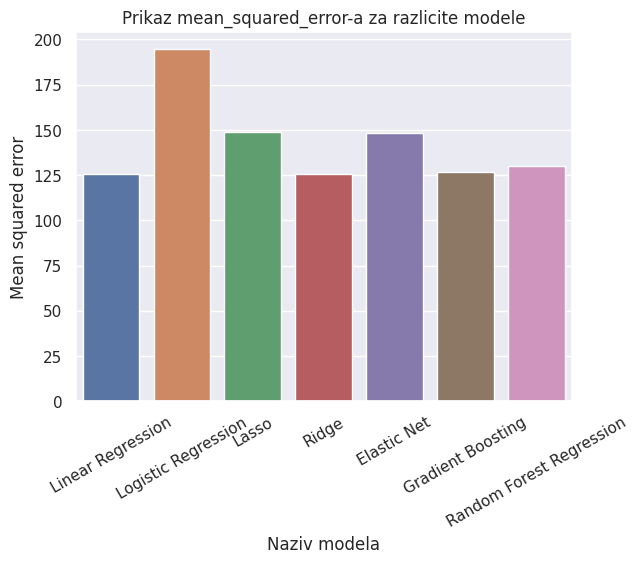

In [45]:
#vizuelizacija dobijenih rezultata za neg_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_mean_squared_error':results_mean_squared_error})
sns.barplot(x = frame['model_name'], y=abs(frame['neg_mean_squared_error']))
print(frame)
title = 'Prikaz mean_squared_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Mean squared error')
plt.show()

                 model_name  neg_root_mean_squared_error
0         Linear Regression                   -11.172718
1       Logistic Regression                   -13.927147
2                     Lasso                   -12.195889
3                     Ridge                   -11.172195
4               Elastic Net                   -12.157890
5         Gradient Boosting                   -11.240330
6  Random Forest Regression                   -11.384714


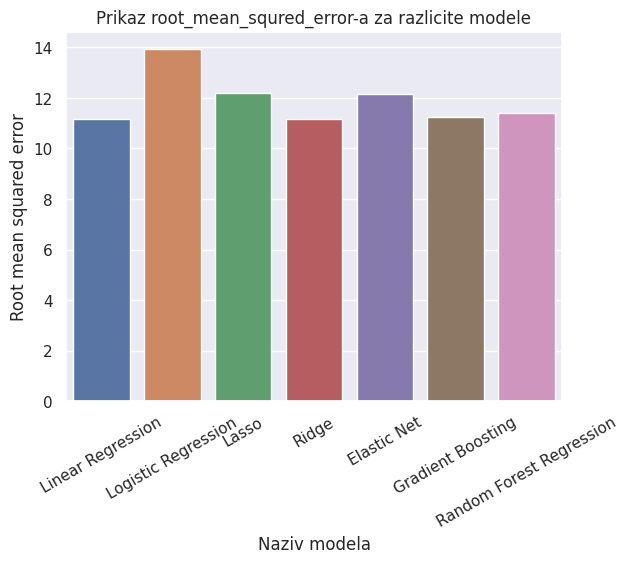

In [46]:
#vizuelizacija dobijenih rezultata za root_mean_squared_error
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'neg_root_mean_squared_error':results_root_mean_squared_error})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['neg_root_mean_squared_error']))
title = 'Prikaz root_mean_squred_error-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('Root mean squared error')
plt.show()

                 model_name        r2
0         Linear Regression  0.361315
1       Logistic Regression  0.007998
2                     Lasso  0.240683
3                     Ridge  0.361385
4               Elastic Net  0.245606
5         Gradient Boosting  0.353222
6  Random Forest Regression  0.336804


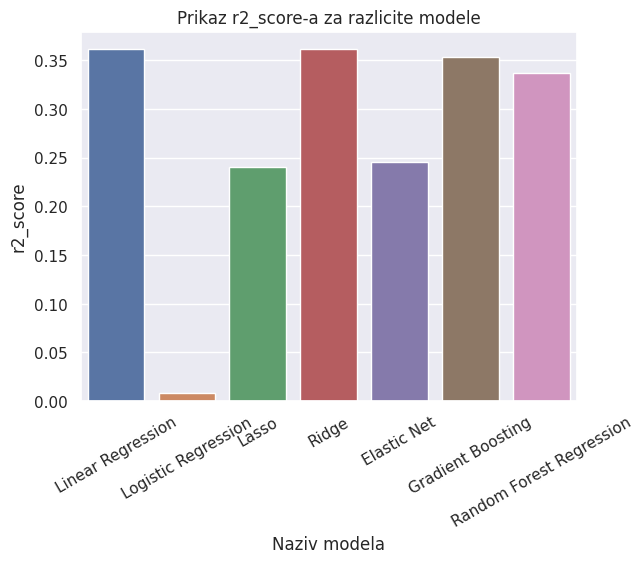

In [47]:
#vizuelizacija dobijenih rezultata za r2_score
sns.set()
#pravljenje novog dataframe-a zbog vizulizacije
frame = pd.DataFrame({'model_name':names, 'r2':results_r2_score})
print(frame)
sns.barplot(x = frame['model_name'], y=abs(frame['r2']))
title = 'Prikaz r2_score-a za razlicite modele'
plt.title(title)
plt.xlabel('Naziv modela')
plt.xticks(rotation=30)
plt.ylabel('r2_score')
plt.show()

In [48]:
#auto-sklearn za regresiju
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30)
automl.fit(X_train, y_train)
print(automl.leaderboard())
test_predictions = automl.predict(X_test)
print("Test R2 score:", r2_score(y_test, test_predictions))

          rank  ensemble_weight           type      cost   duration
model_id                                                           
11           1             0.52  liblinear_svr  0.602076   0.616087
4            2             0.28    extra_trees  0.609489  13.913999
2            3             0.20  random_forest  0.624591   2.463046
Test R2 score: 0.3763771096018068
